In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# from warnings import filterwarnings
# filterwarnings(action='ignore')

In [1]:
%matplotlib inline
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from evalys import visu
from evalys.jobset import JobSet

In [23]:
input_location = 'KTH-io-aware'
files_prefix = ''
schedule_names = ['filler', 'backfill-1', 'no-reserve-1', 'fcfs']

In [24]:
schedule_files = []
jobs_files = []
for file in os.listdir('../output/' + input_location):
    if file.endswith('_schedule.csv'):
        schedule_files.append(file)
    elif file.endswith('_jobs.csv'):
        jobs_files.append(file)

schedule_files = [os.path.join('../output', input_location, str(file)) for file in sorted(schedule_files)]
jobs_files = [os.path.join('../output', input_location, str(file)) for file in sorted(jobs_files)]
print(schedule_files)
print(jobs_files)

['../output/KTH-io-aware/backfill-1_schedule.csv', '../output/KTH-io-aware/balance-largest-1_schedule.csv', '../output/KTH-io-aware/balance-ratio-1_schedule.csv', '../output/KTH-io-aware/balance-smallest-1_schedule.csv', '../output/KTH-io-aware/fcfs_schedule.csv', '../output/KTH-io-aware/filler_schedule.csv', '../output/KTH-io-aware/no-reserve-1_schedule.csv']
['../output/KTH-io-aware/backfill-1_jobs.csv', '../output/KTH-io-aware/balance-11-ratio-1_jobs.csv', '../output/KTH-io-aware/balance-largest-1_jobs.csv', '../output/KTH-io-aware/balance-ratio-1_jobs.csv', '../output/KTH-io-aware/balance-smallest-1_jobs.csv', '../output/KTH-io-aware/fcfs_jobs.csv', '../output/KTH-io-aware/filler_jobs.csv', '../output/KTH-io-aware/no-reserve-1_jobs.csv']


In [25]:
metrics = pd.DataFrame()
for file in schedule_files:
    if files_prefix:
        workload_name, schedule_name, _ = os.path.basename(file).split('_')
    else:
        workload_name = ''
        schedule_name, _ = os.path.basename(file).split('_')
    if workload_name != files_prefix:
        continue
    if schedule_name in schedule_names:
        print(workload_name, schedule_name)
        df = pd.read_csv(file)
        df['schedule'] = schedule_name
        df = df.set_index('schedule')
        metrics = metrics.append(df)

 backfill-1
 fcfs
 filler
 no-reserve-1


In [26]:
jobsets = {}
for file in jobs_files:
    if files_prefix:
        workload_name, schedule_name, _ = os.path.basename(file).split('_')
    else:
        workload_name = ''
        schedule_name, _ = os.path.basename(file).split('_')
    if workload_name != files_prefix:
        continue
    if schedule_name in schedule_names:
        print(workload_name, schedule_name)
        jobsets[schedule_name] = JobSet.from_csv(file)

 backfill-1
 fcfs
 filler
 no-reserve-1


In [27]:
metrics.index.rename(None, inplace=True)
metrics = metrics.reindex(schedule_names)
sns.set_theme(context='talk', style='whitegrid')
# sns.set_theme(style='whitegrid')

In [28]:
def transform_jobset(schedule):
    df = jobsets[schedule].df
    static_jobs = df[df.final_state == 'REJECTED'].set_index('jobID')
    dynamic_jobs = df[df.final_state != 'REJECTED']
    times = dynamic_jobs.groupby('workload_name').agg({'success': 'min', 'final_state': 'max', 'starting_time': 'min', 'finish_time':'max'}).reset_index()
    times['jobID'] = times.workload_name.apply(lambda s: s.split('%')[1])
    times.set_index('jobID', inplace=True)
    times.drop('workload_name', axis=1, inplace=True)
    static_jobs = static_jobs.loc[times.index].drop(['success', 'final_state', 'starting_time', 'finish_time'], axis=1).join(times)
    resources = dynamic_jobs[dynamic_jobs.profile == 'parallel_homogeneous_profile_0'].groupby('workload_name').agg({'allocated_resources': 'first','proc_alloc': 'first'}).reset_index()
    resources['jobID'] = resources.workload_name.apply(lambda s: s.split('%')[1])
    resources.set_index('jobID', inplace=True)
    resources.drop('workload_name', axis=1, inplace=True)
    static_jobs = static_jobs.drop(['allocated_resources', 'proc_alloc'], axis=1).join(resources)
    static_jobs['execution_time'] = static_jobs.finish_time - static_jobs.starting_time
    static_jobs['waiting_time'] = static_jobs.starting_time - static_jobs.submission_time
    static_jobs['turnaround_time'] = static_jobs.finish_time - static_jobs.submission_time
    static_jobs['stretch'] = static_jobs.turnaround_time / static_jobs.execution_time
    return static_jobs

In [30]:
for schedule in schedule_names:
    jobsets[schedule].df = transform_jobset(schedule)

In [31]:
def calculate_compute_utilisation(schedule):
    compute_time = jobsets[schedule].df[['execution_time', 'allocated_resources']].apply(lambda row: row.execution_time * len(row.allocated_resources), axis=1).sum()
    return compute_time / (metrics.loc[schedule].makespan * 96)

def calculate_storage_utilisation(schedule):
    storage_time = jobsets[schedule].df[['execution_time', 'metadata']].apply(lambda row: row.execution_time * row.metadata, axis=1).sum()
    burst_buffer_capacity = 5 * 10**9
    num_burst_buffers = 12
    total_storage_time = metrics.loc[schedule].makespan * num_burst_buffers * burst_buffer_capacity
    return storage_time / total_storage_time

def create_metric_df(metric):
    return pd.concat([jobsets[schedule].df[metric].rename(schedule) for schedule in schedule_names], axis=1)

In [32]:
metrics['compute_utilisation'] = pd.Series({schedule: calculate_compute_utilisation(schedule) for schedule in schedule_names})
metrics['storage_utilisation'] = pd.Series({schedule: calculate_storage_utilisation(schedule) for schedule in schedule_names})

In [33]:
metrics.T

,filler,backfill-1,no-reserve-1,fcfs
batsim_version,4.0.0,4.0.0,4.0.0,4.0.0
consumed_joules,0,0,0,0
makespan,2.88581e+07,2.88052e+07,5.55449e+07,1.38609e+08
max_slowdown,1.00023,1.00024,1.00024,1.00023
max_turnaround_time,22655.2,22655.2,22655.2,22655.2
max_waiting_time,1e-06,1e-06,1e-06,1e-06
mean_slowdown,0.975925,0.975914,0.975917,0.975923
mean_turnaround_time,223.303,223.715,223.251,223.239
mean_waiting_time,0,0,0,0
nb_computing_machines,109,109,109,109


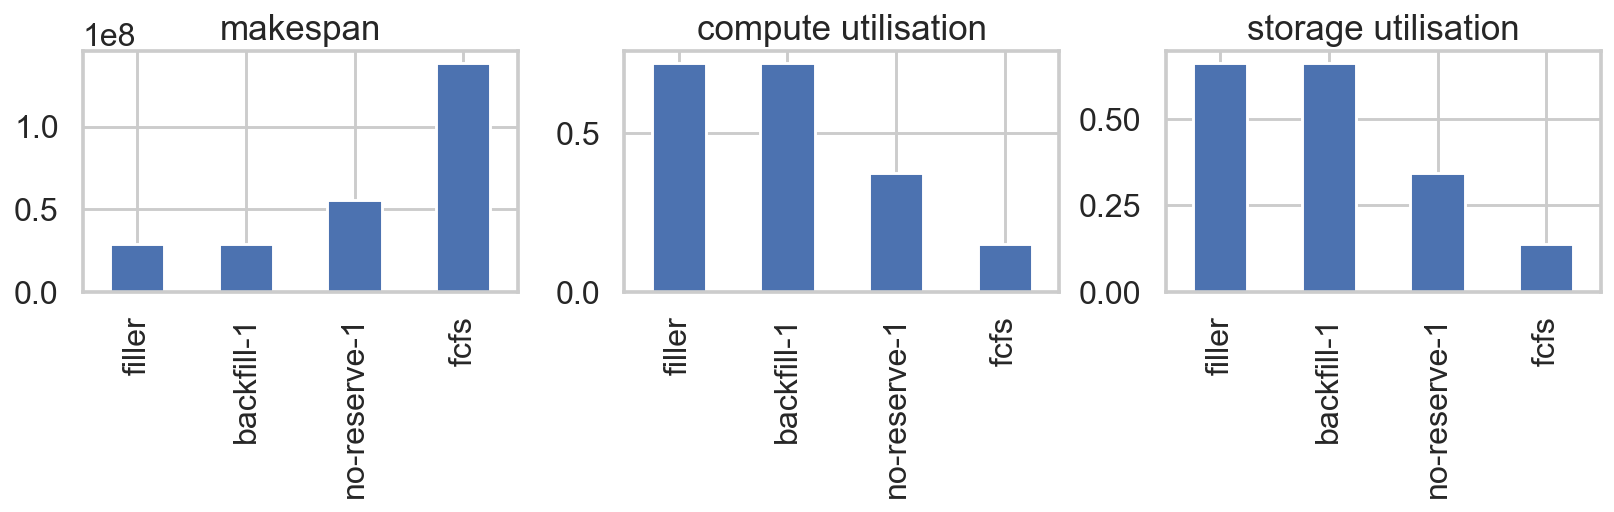

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), dpi=140)
metrics['makespan'].plot.bar(title='makespan', ax=axes[0])
metrics['compute_utilisation'].plot.bar(title='compute utilisation', ax=axes[1])
metrics['storage_utilisation'].plot.bar(title='storage utilisation', ax=axes[2])
fig.tight_layout()

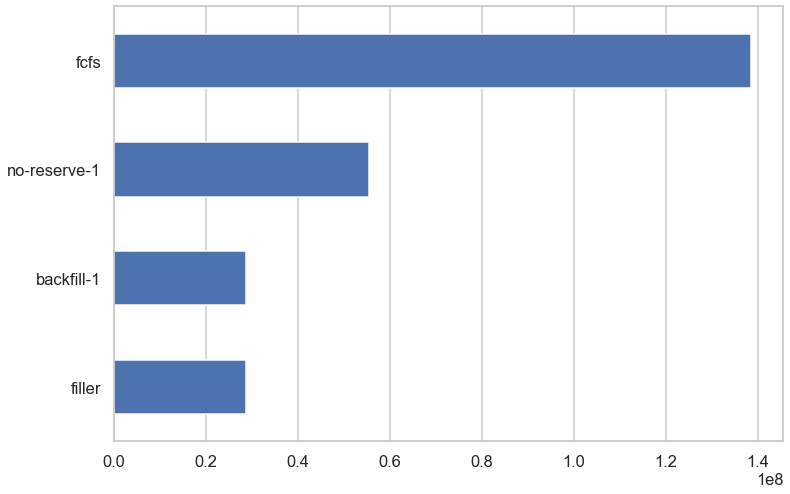

In [35]:
ax = metrics['makespan'].plot.barh(figsize=(12, 8))
ax.grid(axis='y')

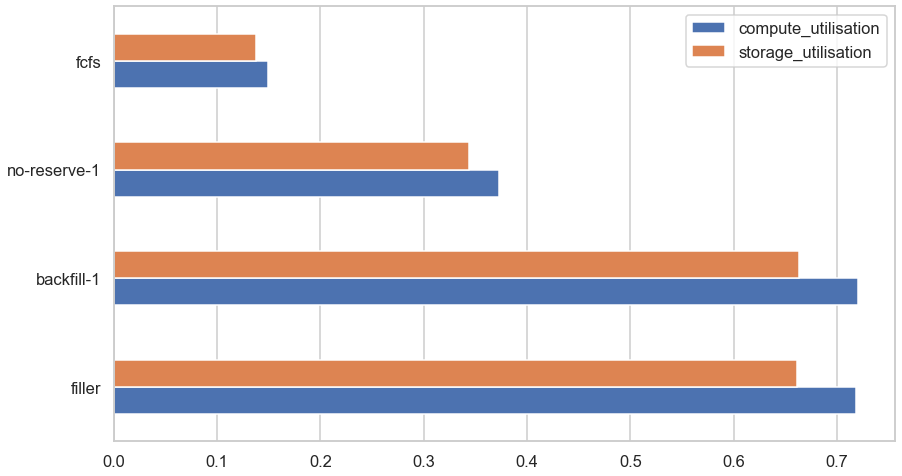

In [36]:
ax = metrics[['compute_utilisation', 'storage_utilisation']].plot.barh(figsize=(14, 8))
ax.grid(axis='y')

In [172]:
df = jobsets['fcfs'].df

In [147]:
static_jobs = df[df.final_state == 'REJECTED'].set_index('jobID')
dynamic_jobs = df[df.final_state != 'REJECTED']

In [148]:
static_jobs

,workload_name,profile,submission_time,requested_number_of_resources,requested_time,success,final_state,starting_time,execution_time,finish_time,waiting_time,turnaround_time,stretch,allocated_resources,metadata,proc_alloc
jobID,,,,,,,,,,,,,,,,
15,w0,15,1.0,4,53940.0,0,REJECTED,NaN,NaN,NaN,NaN,NaN,NaN,[],2.741055e+08,0
16,w0,16,173.0,25,3600.0,0,REJECTED,NaN,NaN,NaN,NaN,NaN,NaN,[],5.773918e+09,0
17,w0,17,627.0,5,215400.0,0,REJECTED,NaN,NaN,NaN,NaN,NaN,NaN,[],1.388898e+10,0
18,w0,18,987.0,17,36000.0,0,REJECTED,NaN,NaN,NaN,NaN,NaN,NaN,[],3.631979e+09,0
19,w0,19,4081.0,8,2400.0,0,REJECTED,NaN,NaN,NaN,NaN,NaN,NaN,[],4.626890e+09,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28486,w0,28486,28758425.0,8,13800.0,0,REJECTED,NaN,NaN,NaN,NaN,NaN,NaN,[],7.945228e+09,0
28487,w0,28487,28758915.0,16,14400.0,0,REJECTED,NaN,NaN,NaN,NaN,NaN,NaN,[],6.268304e+09,0
28488,w0,28488,28762037.0,11,900.0,0,REJECTED,NaN,NaN,NaN,NaN,NaN,NaN,[],5.079417e+09,0


In [149]:
dynamic_jobs

,jobID,workload_name,profile,submission_time,requested_number_of_resources,requested_time,success,final_state,starting_time,execution_time,finish_time,waiting_time,turnaround_time,stretch,allocated_resources,metadata,proc_alloc
1,0,w0%15,data_staging_profile_0,1.000000e+00,2,53940.000000,1,COMPLETED_SUCCESSFULLY,1.000000e+00,0.219384,1.219384e+00,0.0,0.219384,1.000000,"[96, 108]",NaN,2
2,1,w0%15,data_staging_profile_0,1.000000e+00,2,53940.000000,1,COMPLETED_SUCCESSFULLY,1.000000e+00,0.219384,1.219384e+00,0.0,0.219384,1.000000,"[96, 108]",NaN,2
3,2,w0%15,data_staging_profile_0,1.000000e+00,2,53940.000000,1,COMPLETED_SUCCESSFULLY,1.000000e+00,0.219384,1.219384e+00,0.0,0.219384,1.000000,"[96, 108]",NaN,2
4,3,w0%15,data_staging_profile_0,1.000000e+00,2,53940.000000,1,COMPLETED_SUCCESSFULLY,1.000000e+00,0.219384,1.219384e+00,0.0,0.219384,1.000000,"[96, 108]",NaN,2
6,0,w0%16,data_staging_profile_0,1.730000e+02,2,3600.000000,1,COMPLETED_SUCCESSFULLY,1.730000e+02,28.869689,2.018697e+02,0.0,28.869689,1.000000,"[105, 108]",NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182294,1,w0%28489,parallel_homogeneous_profile_0,1.386094e+08,1,29999.572773,1,COMPLETED_SUCCESSFULLY,1.386094e+08,0.400000,1.386094e+08,0.0,0.400000,1.000001,[0],NaN,1
1182295,2,w0%28489,data_staging_profile_0,1.386094e+08,2,29999.172673,1,COMPLETED_SUCCESSFULLY,1.386094e+08,0.427127,1.386094e+08,0.0,0.427128,1.000001,"[96, 108]",NaN,2
1182297,0,w0%28490,data_staging_profile_0,1.386094e+08,2,30000.000000,1,COMPLETED_SUCCESSFULLY,1.386094e+08,1.212666,1.386094e+08,0.0,1.212666,1.000000,"[96, 108]",NaN,2
1182298,1,w0%28490,parallel_homogeneous_profile_0,1.386094e+08,1,29998.787234,1,COMPLETED_SUCCESSFULLY,1.386094e+08,0.400000,1.386094e+08,0.0,0.400000,1.000000,[0],NaN,1


In [150]:
times = dynamic_jobs.groupby('workload_name').agg({'success': 'min', 'final_state': 'max', 'starting_time': 'min', 'finish_time':'max'}).reset_index()
times['jobID'] = times.workload_name.apply(lambda s: s.split('%')[1])
times.set_index('jobID', inplace=True)
times.drop('workload_name', axis=1, inplace=True)
times

,success,final_state,starting_time,finish_time
jobID,,,,
100,1,COMPLETED_SUCCESSFULLY,3.793143e+04,3.813081e+04
1000,1,COMPLETED_SUCCESSFULLY,1.418797e+06,1.418801e+06
10000,1,COMPLETED_SUCCESSFULLY,1.750886e+07,1.750930e+07
10001,1,COMPLETED_SUCCESSFULLY,1.750930e+07,1.751642e+07
10002,1,COMPLETED_SUCCESSFULLY,1.751520e+07,1.752206e+07
...,...,...,...,...
9995,1,COMPLETED_SUCCESSFULLY,1.749425e+07,1.751520e+07
9996,1,COMPLETED_SUCCESSFULLY,1.749430e+07,1.750856e+07
9997,1,COMPLETED_SUCCESSFULLY,1.749460e+07,1.750886e+07


In [151]:
static_jobs = static_jobs.loc[times.index].drop(['success', 'final_state', 'starting_time', 'finish_time'], axis=1).join(times)
static_jobs

,workload_name,profile,submission_time,requested_number_of_resources,requested_time,execution_time,waiting_time,turnaround_time,stretch,allocated_resources,metadata,proc_alloc,success,final_state,starting_time,finish_time
jobID,,,,,,,,,,,,,,,,
100,w0,100,30245.0,1,24000.0,NaN,NaN,NaN,NaN,[],8.108964e+08,0,1,COMPLETED_SUCCESSFULLY,3.793143e+04,3.813081e+04
1000,w0,1000,786556.0,3,600.0,NaN,NaN,NaN,NaN,[],2.923535e+09,0,1,COMPLETED_SUCCESSFULLY,1.418797e+06,1.418801e+06
10000,w0,10000,10967275.0,2,600.0,NaN,NaN,NaN,NaN,[],4.432118e+09,0,1,COMPLETED_SUCCESSFULLY,1.750886e+07,1.750930e+07
10001,w0,10001,10968233.0,8,7200.0,NaN,NaN,NaN,NaN,[],1.165614e+09,0,1,COMPLETED_SUCCESSFULLY,1.750930e+07,1.751642e+07
10002,w0,10002,10969228.0,2,14400.0,NaN,NaN,NaN,NaN,[],1.460707e+09,0,1,COMPLETED_SUCCESSFULLY,1.751520e+07,1.752206e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,w0,9995,10931071.0,10,26400.0,NaN,NaN,NaN,NaN,[],2.717181e+09,0,1,COMPLETED_SUCCESSFULLY,1.749425e+07,1.751520e+07
9996,w0,9996,10960498.0,16,14400.0,NaN,NaN,NaN,NaN,[],3.234603e+09,0,1,COMPLETED_SUCCESSFULLY,1.749430e+07,1.750856e+07
9997,w0,9997,10960681.0,16,14400.0,NaN,NaN,NaN,NaN,[],2.459034e+09,0,1,COMPLETED_SUCCESSFULLY,1.749460e+07,1.750886e+07


In [152]:
resources = dynamic_jobs[dynamic_jobs.profile == 'parallel_homogeneous_profile_0'].groupby('workload_name').agg({'allocated_resources': 'first','proc_alloc': 'first'}).reset_index()
resources['jobID'] = resources.workload_name.apply(lambda s: s.split('%')[1])
resources.set_index('jobID', inplace=True)
resources.drop('workload_name', axis=1, inplace=True)
resources

,allocated_resources,proc_alloc
jobID,,
100,[0],1
1000,"[1, 10, 78]",3
10000,"[24, 25]",2
10001,"[24, 25, 26, 27, 29, 30, 31, 32]",8
10002,"[0, 18]",2
...,...,...
9995,"[0, 1, 10, 18, 28, 38, 48, 58, 68, 78]",10
9996,"[11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 2...",16
9997,"[29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 4...",16


In [153]:
static_jobs = static_jobs.drop(['allocated_resources', 'proc_alloc'], axis=1).join(resources)
static_jobs

,workload_name,profile,submission_time,requested_number_of_resources,requested_time,execution_time,waiting_time,turnaround_time,stretch,metadata,success,final_state,starting_time,finish_time,allocated_resources,proc_alloc
jobID,,,,,,,,,,,,,,,,
100,w0,100,30245.0,1,24000.0,NaN,NaN,NaN,NaN,8.108964e+08,1,COMPLETED_SUCCESSFULLY,3.793143e+04,3.813081e+04,[0],1
1000,w0,1000,786556.0,3,600.0,NaN,NaN,NaN,NaN,2.923535e+09,1,COMPLETED_SUCCESSFULLY,1.418797e+06,1.418801e+06,"[1, 10, 78]",3
10000,w0,10000,10967275.0,2,600.0,NaN,NaN,NaN,NaN,4.432118e+09,1,COMPLETED_SUCCESSFULLY,1.750886e+07,1.750930e+07,"[24, 25]",2
10001,w0,10001,10968233.0,8,7200.0,NaN,NaN,NaN,NaN,1.165614e+09,1,COMPLETED_SUCCESSFULLY,1.750930e+07,1.751642e+07,"[24, 25, 26, 27, 29, 30, 31, 32]",8
10002,w0,10002,10969228.0,2,14400.0,NaN,NaN,NaN,NaN,1.460707e+09,1,COMPLETED_SUCCESSFULLY,1.751520e+07,1.752206e+07,"[0, 18]",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,w0,9995,10931071.0,10,26400.0,NaN,NaN,NaN,NaN,2.717181e+09,1,COMPLETED_SUCCESSFULLY,1.749425e+07,1.751520e+07,"[0, 1, 10, 18, 28, 38, 48, 58, 68, 78]",10
9996,w0,9996,10960498.0,16,14400.0,NaN,NaN,NaN,NaN,3.234603e+09,1,COMPLETED_SUCCESSFULLY,1.749430e+07,1.750856e+07,"[11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 2...",16
9997,w0,9997,10960681.0,16,14400.0,NaN,NaN,NaN,NaN,2.459034e+09,1,COMPLETED_SUCCESSFULLY,1.749460e+07,1.750886e+07,"[29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 4...",16


In [154]:
static_jobs['execution_time'] = static_jobs.finish_time - static_jobs.starting_time
static_jobs['waiting_time'] = static_jobs.starting_time - static_jobs.submission_time
static_jobs['turnaround_time'] = static_jobs.finish_time - static_jobs.submission_time
static_jobs['stretch'] = static_jobs.turnaround_time / static_jobs.execution_time

In [171]:
static_jobs

,workload_name,profile,submission_time,requested_number_of_resources,requested_time,execution_time,waiting_time,turnaround_time,stretch,metadata,success,final_state,starting_time,finish_time,allocated_resources,proc_alloc
jobID,,,,,,,,,,,,,,,,
100,w0,100,30245.0,1,24000.0,199.376073,7.686430e+03,7.885806e+03,39.552418,8.108964e+08,1,COMPLETED_SUCCESSFULLY,3.793143e+04,3.813081e+04,[0],1
1000,w0,1000,786556.0,3,600.0,4.309042,6.322407e+05,6.322450e+05,146725.183583,2.923535e+09,1,COMPLETED_SUCCESSFULLY,1.418797e+06,1.418801e+06,"[1, 10, 78]",3
10000,w0,10000,10967275.0,2,600.0,438.718529,6.541585e+06,6.542024e+06,14911.665217,4.432118e+09,1,COMPLETED_SUCCESSFULLY,1.750886e+07,1.750930e+07,"[24, 25]",2
10001,w0,10001,10968233.0,8,7200.0,7123.696232,6.541066e+06,6.548190e+06,919.212346,1.165614e+09,1,COMPLETED_SUCCESSFULLY,1.750930e+07,1.751642e+07,"[24, 25, 26, 27, 29, 30, 31, 32]",8
10002,w0,10002,10969228.0,2,14400.0,6859.595610,6.545972e+06,6.552832e+06,955.279612,1.460707e+09,1,COMPLETED_SUCCESSFULLY,1.751520e+07,1.752206e+07,"[0, 18]",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,w0,9995,10931071.0,10,26400.0,20953.400584,6.563176e+06,6.584129e+06,314.227240,2.717181e+09,1,COMPLETED_SUCCESSFULLY,1.749425e+07,1.751520e+07,"[0, 1, 10, 18, 28, 38, 48, 58, 68, 78]",10
9996,w0,9996,10960498.0,16,14400.0,14259.251447,6.533803e+06,6.548062e+06,459.214980,3.234603e+09,1,COMPLETED_SUCCESSFULLY,1.749430e+07,1.750856e+07,"[11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 2...",16
9997,w0,9997,10960681.0,16,14400.0,14264.710234,6.533914e+06,6.548179e+06,459.047468,2.459034e+09,1,COMPLETED_SUCCESSFULLY,1.749460e+07,1.750886e+07,"[29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 4...",16


In [176]:
backfill_df = transform_jobset(jobsets['backfill-1'])
fcfs_df = transform_jobset(jobsets['fcfs'])
filler_df = transform_jobset(jobsets['filler'])
nores_backfill_df = transform_jobset(jobsets['nores-backfill-1'])

In [181]:
all_dfs = [(backfill_df, 'backfill-1'), (fcfs_df, 'fcfs'), (filler_df, 'filler'), (nores_backfill_df, 'nores-backfill-1')]

In [179]:
def create_metric_df(metric, dfs):
    return pd.concat([df[metric].rename(schedule) for df, schedule in dfs], axis=1)

In [183]:
waiting_times = create_metric_df('waiting_time', all_dfs)

In [184]:
waiting_times

,backfill-1,fcfs,filler,nores-backfill-1
jobID,,,,
100,0.000000,7.686430e+03,0.000000,0.000000e+00
1000,0.000000,6.322407e+05,0.000000,3.080494e+03
10000,0.000000,6.541585e+06,21927.791108,1.064460e+05
10001,0.000000,6.541066e+06,6699.489398,1.631305e+07
10002,0.000000,6.545972e+06,12831.436038,1.049317e+05
...,...,...,...,...
9995,36870.759753,6.563176e+06,6145.539002,2.250874e+07
9996,7858.429175,6.533803e+06,183.000000,2.940824e+07
9997,21934.684721,6.533914e+06,14251.489398,2.942232e+07


<AxesSubplot:>

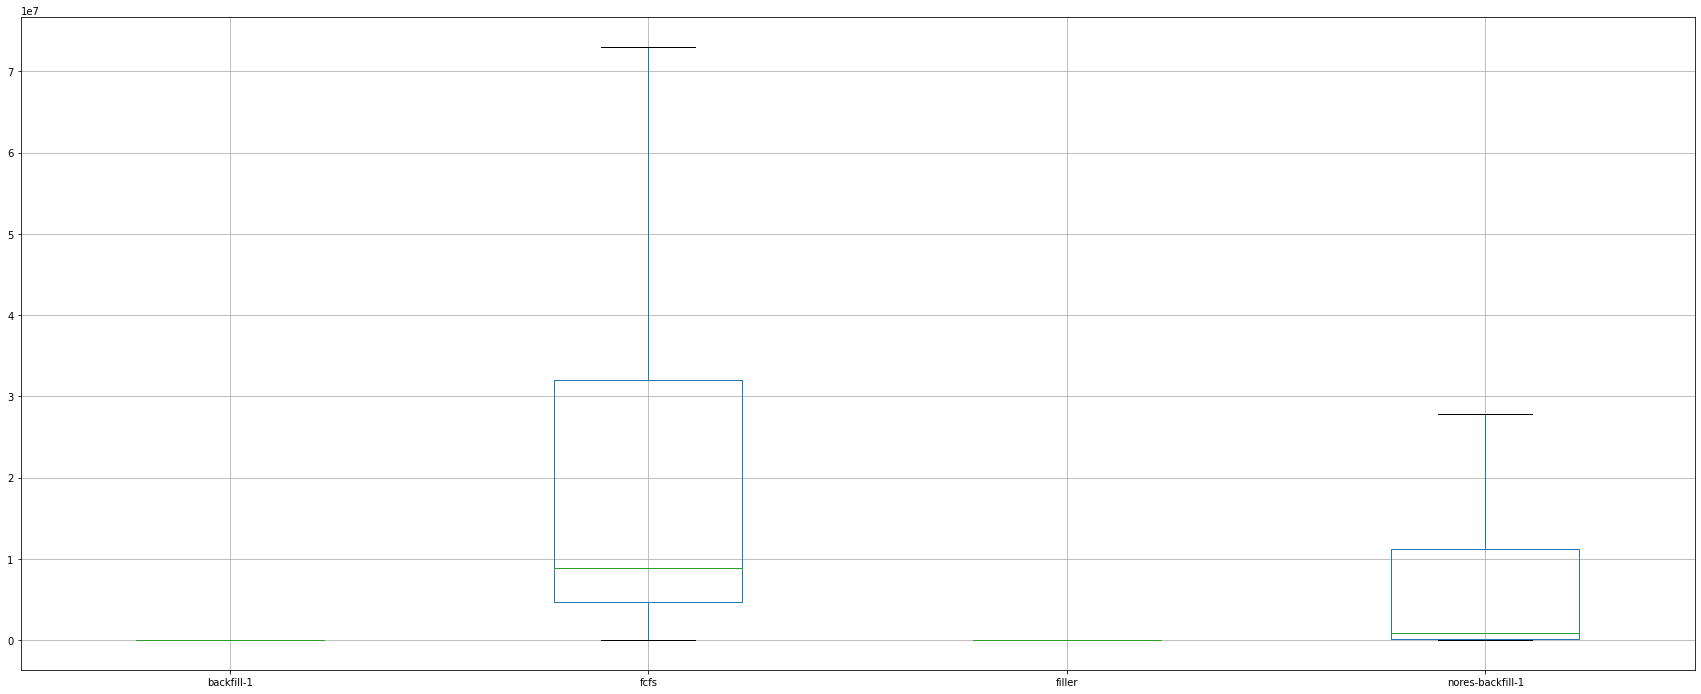

In [187]:
waiting_times.boxplot(showfliers=False, figsize=(30,12))

<AxesSubplot:>

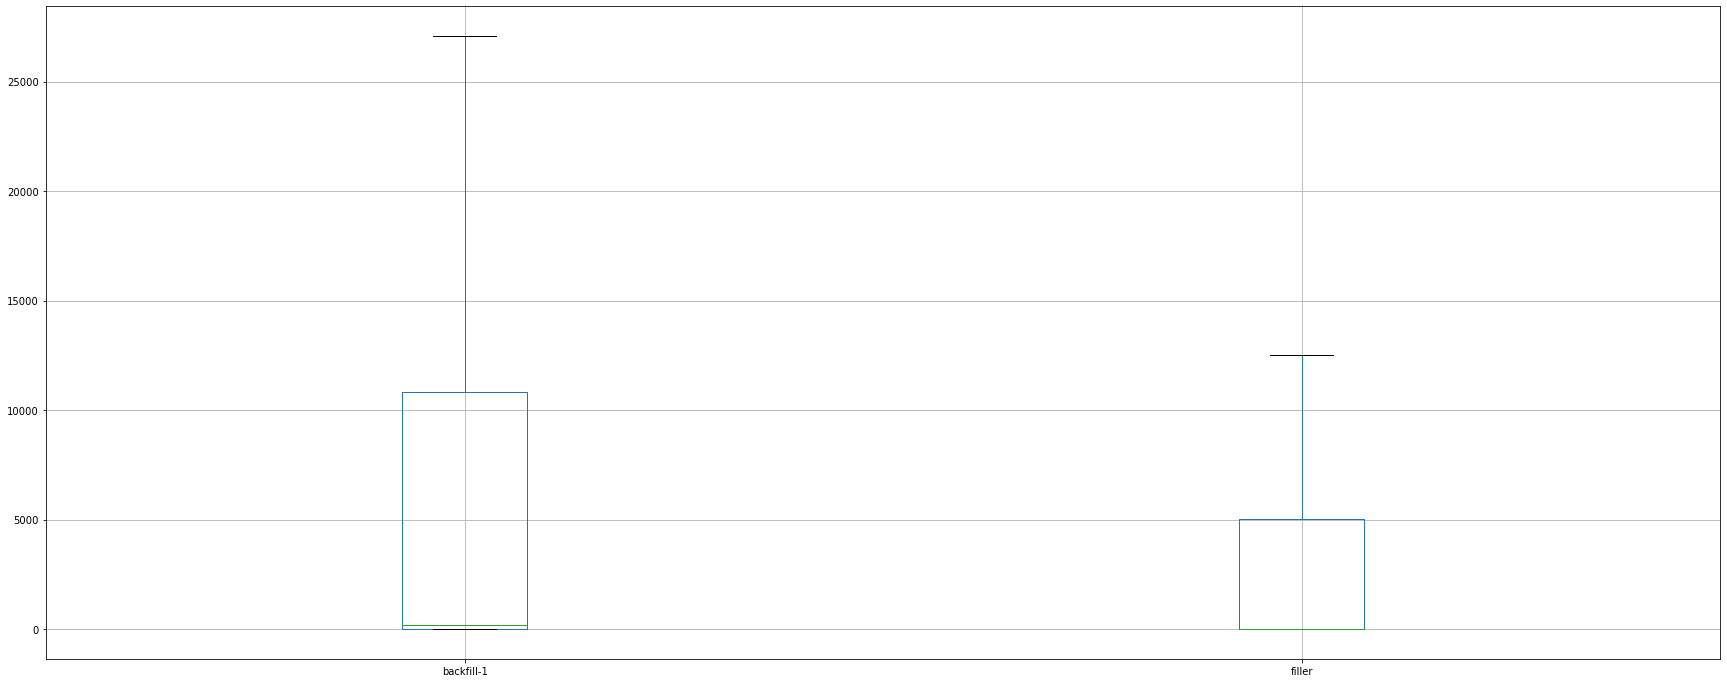

In [200]:
waiting_times.drop(['fcfs', 'nores-backfill-1'], axis=1).boxplot(showfliers=False, figsize=(30,12))

In [193]:
slowdown = create_metric_df('stretch', all_dfs)

<AxesSubplot:>

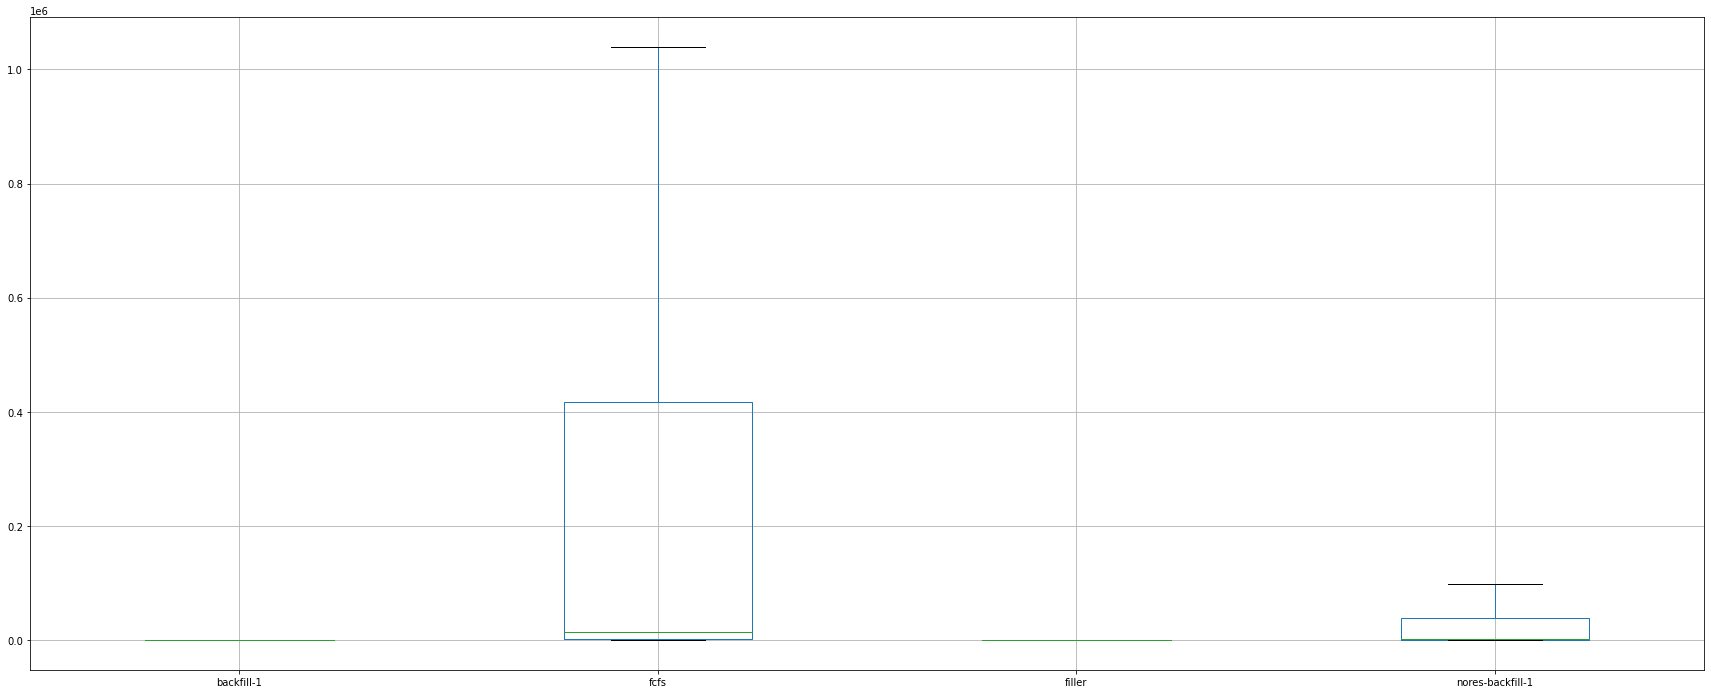

In [194]:
slowdown.boxplot(showfliers=False, figsize=(30,12))

<AxesSubplot:>

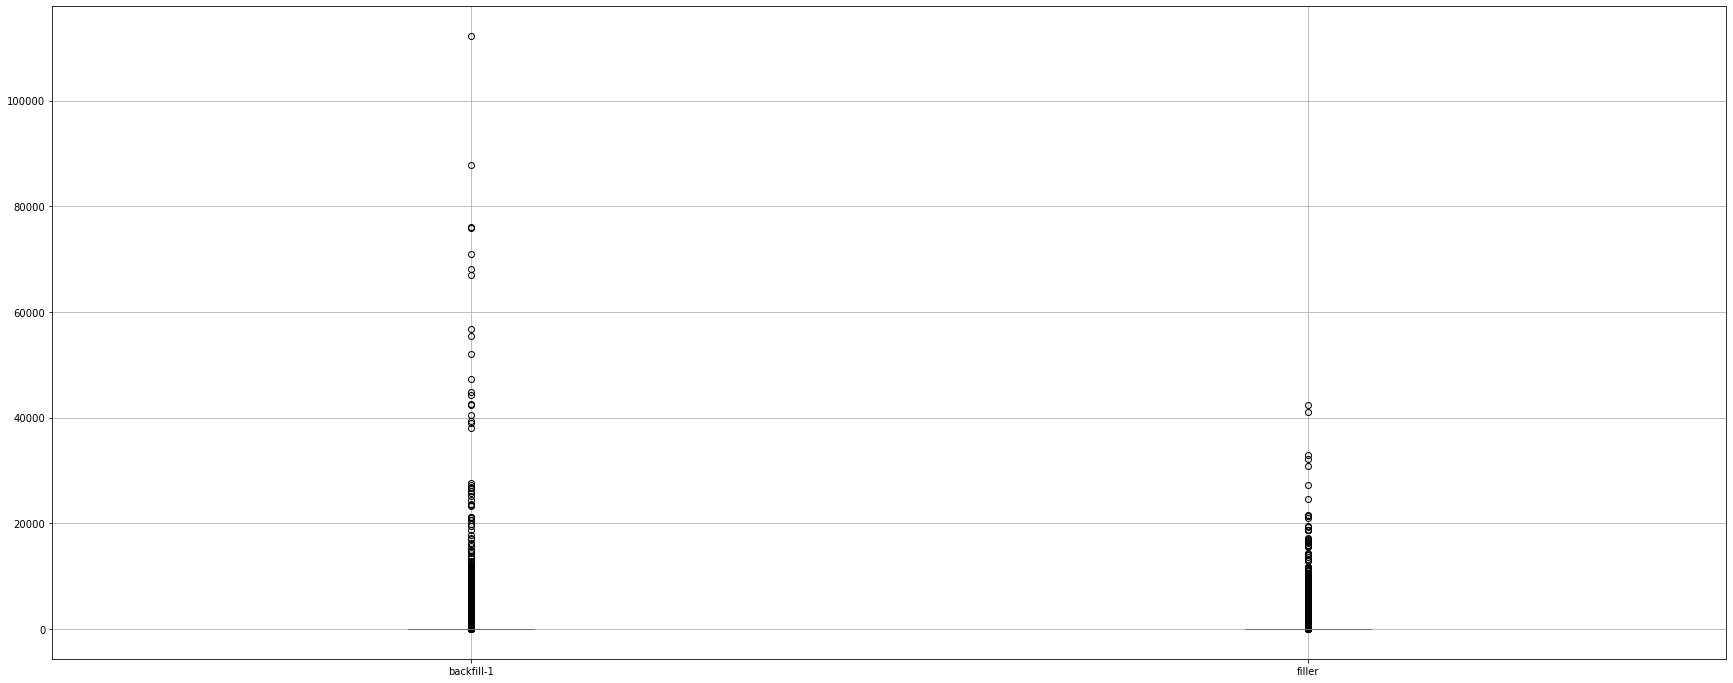

In [201]:
slowdown.drop(['fcfs', 'nores-backfill-1'], axis=1).boxplot(showfliers=True, figsize=(30,12))